In [1]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from imageio import imread
from skimage.transform import resize
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans

import keras
import tensorflow as tf
from keras import backend as K
from keras.applications.vgg16 import preprocess_input
import PIL.Image
#}

Using TensorFlow backend.


Model architecture
<img src="../../data/misc/vgg16.png">

In [2]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [3]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        '''
        img = imread(im_path,as_gray=False, pilmode="RGB")
        #print im_path
        #print img.shape
        if img_size:
            img = resize(img, img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode == 'bgr':
            img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
        img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[:, (img_size[0] - crop_size[0]) // 2:(img_size[0] + crop_size[0]) // 2
            , (img_size[1] - crop_size[1]) // 2:(img_size[1] + crop_size[1]) // 2]

        img_list.append(img)
        '''
        size = 224
        ret = PIL.Image.open(im_path)
        ret = ret.resize((size, size))
        ret = np.asarray(ret, dtype=np.uint8).astype(np.float32)
        #ret[:, :, 0] -= 123.68
        #ret[:, :, 1] -= 116.779
        #ret[:, :, 2] -= 103.939
        if ret.ndim == 2:
            ret.resize((size, size, 1))
            ret = np.repeat(ret, 3, axis=-1)
        #ret = ret.transpose((2, 0, 1))
        #ret = np.flip(ret,0)
        x = preprocess_input(ret)
        img_list.append(x)
        

    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print(im_path)
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [4]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i][0:5]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error

In [5]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids

In [6]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1
#}

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from keras import layers
from keras import models
import keras.utils as keras_utils
from keras.layers import Lambda

from  keras.applications import imagenet_utils
from  keras.applications.imagenet_utils import decode_predictions
from  keras_applications.imagenet_utils import _obtain_input_shape

preprocess_input = imagenet_utils.preprocess_input

WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.1/'
                'vgg16_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.1/'
                       'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')


def VGG16(include_top=True,
          weights='imagenet',
          input_tensor=None,
          input_shape=None,
          pooling=None,
          classes=1000,
          lambda_mask=None,
          **kwargs):
    
    backend= keras.backend
    layers = keras.layers
    models = keras.models
    keras_utils = tf.keras.utils
    
    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    
    if lambda_mask is not None:
        block_1_conv_1_mask  = np.reshape(lambda_mask[0:3211264], (224, 224,64))
    else:
        block_1_conv_1_mask = np.ones(shape=((224, 224, 64)))
    
    block_1_conv_1_mask  = backend.variable(block_1_conv_1_mask)
    block_1_conv_1_lambda = Lambda(lambda x: x * block_1_conv_1_mask)(x)
    
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(block_1_conv_1_lambda)
    
    if lambda_mask is not None:
        block_1_conv_2_mask  = np.reshape(lambda_mask[3211264:6422528], (224, 224, 64))
    else:
        block_1_conv_2_mask = np.ones(shape=((224, 224, 64)))
    
    block_1_conv_2_mask  = backend.variable(block_1_conv_2_mask)
    block_1_conv_2_lambda = Lambda(lambda x: x * block_1_conv_2_mask)(x)
    
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(block_1_conv_2_lambda)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    
    if lambda_mask is not None:
        block_2_conv_1_mask  = np.reshape(lambda_mask[6422528:8028160], (112, 112, 128))
    else:
        block_2_conv_1_mask = np.ones(shape=((112, 112, 128)))
    
    block_2_conv_1_mask  = backend.variable(block_2_conv_1_mask)
    block_2_conv_1_lambda = Lambda(lambda x: x * block_2_conv_1_mask)(x)
    
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(block_2_conv_1_lambda)
    
    
    if lambda_mask is not None:
        block_2_conv_2_mask  = np.reshape(lambda_mask[8028160:9633792], (112, 112, 128))
    else:
        block_2_conv_2_mask = np.ones(shape=((112, 112, 128)))
    
    block_2_conv_2_mask  = backend.variable(block_2_conv_2_mask)
    block_2_conv_2_lambda = Lambda(lambda x: x * block_2_conv_2_mask)(x)
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(block_2_conv_2_lambda)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    
    if lambda_mask is not None:
        block_3_conv_1_mask  = np.reshape(lambda_mask[9633792:10436608], (56, 56, 256))
    else:
        block_3_conv_1_mask = np.ones(shape=((56, 56, 256)))
    
    block_3_conv_1_mask  = backend.variable(block_3_conv_1_mask)
    block_3_conv_1_lambda = Lambda(lambda x: x * block_3_conv_1_mask)(x)
    
    
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(block_3_conv_1_lambda)
    
    if lambda_mask is not None:
        block_3_conv_2_mask  = np.reshape(lambda_mask[10436608:11239424], (56, 56, 256))
    else:
        block_3_conv_2_mask = np.ones(shape=((56, 56, 256)))
    
    block_3_conv_2_mask  = backend.variable(block_3_conv_2_mask)
    block_3_conv_2_lambda = Lambda(lambda x: x * block_3_conv_2_mask)(x)
    
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')( block_3_conv_2_lambda)
    
    if lambda_mask is not None:
        block_3_conv_3_mask  = np.reshape(lambda_mask[11239424:12042240], (56, 56, 256))
    else:
        block_3_conv_3_mask = np.ones(shape=((56, 56, 256)))
    
    block_3_conv_3_mask  = backend.variable(block_3_conv_3_mask)
    block_3_conv_3_lambda = Lambda(lambda x: x * block_3_conv_3_mask)(x)
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(block_3_conv_3_lambda)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    
    if lambda_mask is not None:
        block_4_conv_1_mask  = np.reshape(lambda_mask[12042240:12443648], (28, 28, 512))
    else:
        block_4_conv_1_mask = np.ones(shape=((28, 28, 512)))
    
    block_4_conv_1_mask  = backend.variable(block_4_conv_1_mask)
    block_4_conv_1_lambda = Lambda(lambda x: x * block_4_conv_1_mask)(x)
    
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(block_4_conv_1_lambda)
    
    if lambda_mask is not None:
        block_4_conv_2_mask  = np.reshape(lambda_mask[12443648:12845056], (28, 28, 512))
    else:
        block_4_conv_2_mask = np.ones(shape=((28, 28, 512)))
    
    block_4_conv_2_mask  = backend.variable(block_4_conv_2_mask)
    block_4_conv_2_lambda = Lambda(lambda x: x * block_4_conv_2_mask)(x)
    
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(block_4_conv_2_lambda)
    
    
    if lambda_mask is not None:
        block_4_conv_3_mask  = np.reshape(lambda_mask[12845056:13246464], (28, 28, 512))
    else:
        block_4_conv_3_mask = np.ones(shape=((28, 28, 512)))
    
    block_4_conv_3_mask  = backend.variable(block_4_conv_3_mask)
    block_4_conv_3_lambda = Lambda(lambda x: x * block_4_conv_3_mask)(x)
    
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')( block_4_conv_3_lambda)

    # Block 5
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1')(x)
    
    if lambda_mask is not None:
        block_5_conv_1_mask  = np.reshape(lambda_mask[13246464:13346816], (14, 14, 512))
    else:
        block_5_conv_1_mask = np.ones(shape=((14, 14, 512)))
    
    block_5_conv_1_mask  = backend.variable(block_5_conv_1_mask)
    block_5_conv_1_lambda = Lambda(lambda x: x * block_5_conv_1_mask)(x)
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2')(block_5_conv_1_lambda)
    
    if lambda_mask is not None:
        block_5_conv_2_mask  = np.reshape(lambda_mask[13346816:13447168], (14, 14, 512))
    else:
        block_5_conv_2_mask = np.ones(shape=((14, 14, 512)))
    
    block_5_conv_2_mask  = backend.variable(block_5_conv_2_mask)
    block_5_conv_2_lambda = Lambda(lambda x: x * block_5_conv_2_mask)(x)
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(block_5_conv_2_lambda)
    
    if lambda_mask is not None:
        block_5_conv_3_mask  = np.reshape(lambda_mask[13447168:13547520], (14, 14, 512))
    else:
        block_5_conv_3_mask = np.ones(shape=((14, 14, 512)))
    
    block_5_conv_3_mask  = backend.variable(block_5_conv_3_mask)
    block_5_conv_3_lambda = Lambda(lambda x: x * block_5_conv_3_mask)(x)
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')( block_5_conv_3_lambda)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(4096, activation='relu', name='fc1')(x)
        
        if lambda_mask is not None:
            block_fc1_mask  = np.reshape(lambda_mask[13547520:13551616], (4096,))
        else:
            block_fc1_mask = np.ones(shape=((4096,)))
        block_fc1_mask  = backend.variable(block_fc1_mask)
        block_fc1_lambda = Lambda(lambda x: x * block_fc1_mask)(x)
    
        x = layers.Dense(4096, activation='relu', name='fc2')(block_fc1_lambda)
        
        if lambda_mask is not None:
            block_fc2_mask  = np.reshape(lambda_mask[13551616:13555712], (4096,))
        else:
            block_fc2_mask = np.ones(shape=((4096,)))
        block_fc2_mask  = backend.variable(block_fc2_mask)
        block_fc2_lambda = Lambda(lambda x: x * block_fc2_mask)(x)
        
        x = layers.Dense(classes, activation='softmax', name='predictions')(block_fc2_lambda)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='vgg16')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                file_hash='64373286793e3c8b2b4e3219cbf3544b')
        else:
            weights_path = keras_utils.get_file(
                'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                file_hash='6d6bbae143d832006294945121d1f1fc')
        model.load_weights(weights_path)
        if backend.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)

    return model

In [8]:
model_name = 'VGG16'
model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
model.summary()







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
lambda_1 (Lambda)            (None, 224, 224, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
lambda_2 (Lambda)            (None, 224, 224, 64)      0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
____

In [9]:
import gc
K.image_data_format()
keras.backend.clear_session()
gc.collect()
del model

In [ ]:
%%time
#Test Cell 1

data_path = '../../data/pkl_vgg16/'
classes = ['animate','inanimate']
fold = 1

with open(data_path+classes[0]+'_train_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_train_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)
    
X = np.column_stack((X_fold,y_fold))
X = np.float32(X)


kmeans = MiniBatchKMeans(n_clusters=67783, #200x reduction in points
                         max_iter=10).fit(X)

pred_kmeans = kmeans.predict(X)

X_new = kmeans.cluster_centers_

with open('../../data/pkl_vgg16/kmeans_first_train_'+model_name+'.pkl', 'wb') as handle:
    pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [10]:
#%%time
#Version 1 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl_vgg16/'
classes = ['animate','inanimate']

from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.mixture import GaussianMixture

result= {}

model_name = 'VGG16'
k = 4 #Total Number of folds
fold = 1

for i in range(k):
    if i==1: break
    
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    if os.path.exists('../../data/pkl_vgg16/kmeans_first_'+str(fold)+'_'+model_name+'.pkl'):
        with open('../../data/pkl_vgg16/kmeans_first_'+str(fold)+'_'+model_name+'.pkl',"rb") as f:
            X_new,pred_kmeans,kmeans = pickle.load(f)
    else:   
        with open(data_path+classes[0]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            X_fold = pickle.load(f)
        with open(data_path+classes[1]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            y_fold = pickle.load(f)

        X = np.column_stack((X_fold,y_fold))
        kmeans = MiniBatchKMeans(n_clusters=67783, random_state=42).fit(X) #200x Reduction in cluster size
        #print kmeans.cluster_centers_
        pred_kmeans = kmeans.predict(X)
        X_new = kmeans.cluster_centers_

        with open('../../data/pkl_vgg16/kmeans_first_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
            pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

    #DO CLUSTERING AND GET CLUSTERS
    
    
    method ='GMM'
    print(method)
    for j in range(1,14,1):
 
        clf_result[j] = {}
        print(j,2**j)
        #clf = KMeans(n_clusters=j)    
        clf = GaussianMixture(n_components=2**j, covariance_type='full', random_state=42)
        y_pred = clf.fit_predict(X_new)
        #print clf.cluster_centers_

        for label in set(y_pred):
            print('Cluster: ',j,'Label: ', label)
            
            #Lesioning and measuring performance
            pred = y_pred.copy()
            loc = np.where(pred==label)
            loc_temp = kmeans.predict(X_new[loc[0]])
            loc_new =[]
            for entry in set(loc_temp):
                temp = np.where(pred_kmeans==entry)[0]
                loc_new.extend(temp)

            lambda_mask = np.ones(shape=((13555712,)))
            lambda_mask[loc_new] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 
            #Change Model
            model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl_vgg16/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'r') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

                print(str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error))
                
                if flag == 0:
                    dprime = error
                    flag = 1
                else:
                    dprime -= error
                    
            keras.backend.clear_session()
            gc.collect()
            del model
            clf_result[j][label] = dprime
    
    with open('../../data/pkl_vgg16/'+str(method)+'_multi_scree_fold_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump(clf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    result[fold] = clf_result
    fold += 1
#}

Perfoming Fold:  1
GMM
1 2
Cluster:  1 Label:  0
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  1 Label:  1
animate 1 0 39 1.0
inanimate 1 0 39 1.0
2 4
Cluster:  2 Label:  0
animate 1 36 39 0.07692307692307687
inanimate 1 32 39 0.17948717948717952
Cluster:  2 Label:  1
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  2 Label:  2
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  2 Label:  3
animate 1 0 39 1.0
inanimate 1 7 39 0.8205128205128205
3 8
Cluster:  3 Label:  0
animate 1 0 39 1.0
inanimate 1 29 39 0.2564102564102564
Cluster:  3 Label:  1
animate 1 0 39 1.0
inanimate 1 1 39 0.9743589743589743
Cluster:  3 Label:  2
animate 1 33 39 0.15384615384615385
inanimate 1 13 39 0.6666666666666667
Cluster:  3 Label:  3
animate 1 36 39 0.07692307692307687
inanimate 1 36 39 0.07692307692307687
Cluster:  3 Label:  4
animate 1 5 39 0.8717948717948718
inanimate 1 0 39 1.0
Cluster:  3 Label:  5
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  3 Label:  6
animate 1 4 39 0.8974358974358975
ina

animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  6 Label:  28
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  6 Label:  29
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  6 Label:  30
animate 1 36 39 0.07692307692307687
inanimate 1 32 39 0.17948717948717952
Cluster:  6 Label:  31
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  6 Label:  32
animate 1 33 39 0.15384615384615385
inanimate 1 33 39 0.15384615384615385
Cluster:  6 Label:  33
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  6 Label:  34
animate 1 35 39 0.10256410256410253
inanimate 1 32 39 0.17948717948717952
Cluster:  6 Label:  35
animate 1 35 39 0.10256410256410253
inanimate 1 32 39 0.17948717948717952
Cluster:  6 Label:  36
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  6 Label:  37
animate 1 35 39 0.10256410256410

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  7 Label:  49
animate 1 36 39 0.07692307692307687
inanimate 1 35 39 0.10256410256410253
Cluster:  7 Label:  50
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  7 Label:  51
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  7 Label:  52
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  7 Label:  53
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  7 Label:  54
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  7 Label:  55
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  7 Label:  56
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  7 Label:  57
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  7 Label:  58
animate 1 35 39 0.10256410256410253

animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  6
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  7
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  8
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  9
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  8 Label:  10
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  11
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  12
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  8 Label:  13
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  8 Label:  14
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  15
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
C

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  92
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  93
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  94
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  95
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  96
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  97
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  98
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  99
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  100
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  101
animate 1 36 39 0.07692307692307687
in

inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  176
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  177
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  178
animate 1 35 39 0.10256410256410253
inanimate 1 31 39 0.20512820512820518
Cluster:  8 Label:  179
animate 1 36 39 0.07692307692307687
inanimate 1 35 39 0.10256410256410253
Cluster:  8 Label:  180
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  181
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  182
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  183
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  184
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  8 Label:  185
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051

animate 1 36 39 0.07692307692307687
inanimate 1 35 39 0.10256410256410253
Cluster:  9 Label:  5
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  6
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  7
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  8
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  9
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  10
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  11
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  12
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  13
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  14
animate 1 36 39 0.07692307692307687
inanimat

inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  90
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  91
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  92
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  93
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  94
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  95
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  96
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  97
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  98
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  99
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Clu

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  175
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  176
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  177
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  178
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  179
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  180
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  181
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  182
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  183
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  184
animate 1 35 39 0.10256410256

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  260
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  261
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  262
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  263
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  264
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  265
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  266
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  267
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  268
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  9 Label:  269
animate 1 36 39 0.07692307692

inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  344
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  345
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  346
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  347
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  348
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  349
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  350
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  351
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  352
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  353
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  429
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  430
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  431
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  432
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  433
animate 1 36 39 0.07692307692307687
inanimate 1 35 39 0.10256410256410253
Cluster:  9 Label:  434
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  435
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  436
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  437
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  438
animate 1 35 39 0.10256410256

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  2
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  3
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  4
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  5
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  6
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  7
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  8
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  9
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  10
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  11
animate 1 36 39 0.07692307692307687
in

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  87
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  88
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  89
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  90
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  91
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  92
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  93
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  94
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  95
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  96
animate 1 36 39 0.07692307692

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  171
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  172
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  173
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  174
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  175
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  176
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  177
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  178
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  179
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  180
animate 1 36 39 0.07

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  255
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  256
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  257
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  258
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  259
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  260
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  261
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  262
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  263
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  264
animate 1 35 39 0.10

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  339
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  340
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  341
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  342
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  343
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  344
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  10 Label:  345
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  346
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  347
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  348
animate 1 35 39 0.1

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  423
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  424
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  425
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  426
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  427
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  428
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  429
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  430
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  431
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  432
animate 1 36 39 0.07

animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  507
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  508
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  509
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  510
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  511
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  512
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  513
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  10 Label:  514
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  515
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  516
animate 1 36 39 0.

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  591
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  592
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  593
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  594
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  595
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  596
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  597
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  598
animate 1 36 39 0.07692307692307687
inanimate 1 32 39 0.17948717948717952
Cluster:  10 Label:  599
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  600
animate 1 36 39 0.0

animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  675
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  676
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  677
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  678
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  679
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  680
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  681
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  682
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  683
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  684
animate 1 36 39 0.

animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  10 Label:  759
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  760
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  761
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  762
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  763
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  764
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  765
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  766
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  767
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  768
animate 1 36 39 0.0

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  843
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  844
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  845
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  846
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  847
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  848
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  10 Label:  849
animate 1 34 39 0.1282051282051282
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  850
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  851
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  852
animate 1 35 39 0.10

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  927
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  928
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  929
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  930
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  931
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  932
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  933
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  934
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  935
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  936
animate 1 35 39 0.10

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  1011
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  1012
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  1013
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  1014
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  1015
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  1016
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  1017
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  1018
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  1019
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  10 Label:  1020
animate 1 

inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  71
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  72
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  73
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  74
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  75
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  76
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  77
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  78
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  79
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  80
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282

inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  155
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  156
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  157
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  158
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  159
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  160
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  161
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  162
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  163
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  164
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.

inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  239
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  240
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  241
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  242
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  243
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  244
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  245
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  246
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  247
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  248
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  323
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  324
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  325
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  326
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  327
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  328
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  329
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  330
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  331
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  332
animate 1 35 39 0.10

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  407
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  408
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  409
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  410
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  411
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  412
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  413
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  414
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  415
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  416
animate 1 35 39 0.10

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  491
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  492
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  493
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  494
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  495
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  496
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  497
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  498
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  499
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  500
animate 1 36 39 0.07

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  575
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  576
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  577
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  578
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  579
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  580
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  581
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  582
animate 1 36 39 0.07692307692307687
inanimate 1 31 39 0.20512820512820518
Cluster:  11 Label:  583
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  584
animate 1 36 39 0.

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  659
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  660
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  661
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  662
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  663
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  664
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  665
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  666
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  667
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  668
animate 1 36 39 0.07

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  743
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  744
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  745
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  746
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  747
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  748
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  749
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  750
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  751
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  752
animate 1 35 39 0.10

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  827
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  828
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  829
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  830
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  831
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  832
animate 1 36 39 0.07692307692307687
inanimate 1 35 39 0.10256410256410253
Cluster:  11 Label:  833
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  834
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  835
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  836
animate 1 35 39 0.1

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  911
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  912
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  913
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  914
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  915
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  916
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  917
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  918
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  919
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  920
animate 1 35 39 0.10

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  995
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  996
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  997
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  998
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  999
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1000
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1001
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1002
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1003
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1004
animate 1 36 39

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1078
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1079
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1080
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1081
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1082
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1083
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1084
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1085
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1086
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1087
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1161
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1162
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1163
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1164
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1165
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1166
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1167
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1168
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1169
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1170
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1244
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1245
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1246
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1247
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1248
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1249
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1250
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1251
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1252
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1253
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1327
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1328
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1329
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1330
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1331
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1332
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1333
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1334
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1335
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1336
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1410
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1411
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1412
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1413
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1414
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1415
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1416
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1417
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1418
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1419
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1493
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1494
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1495
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1496
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1497
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  11 Label:  1498
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1499
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1500
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1501
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1502
animate 1

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1576
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1577
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1578
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1579
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1580
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1581
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1582
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1583
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1584
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1585
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1659
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1660
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1661
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1662
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1663
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1664
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1665
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1666
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1667
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1668
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1742
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1743
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1744
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1745
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1746
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1747
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1748
animate 1 36 39 0.07692307692307687
inanimate 1 32 39 0.17948717948717952
Cluster:  11 Label:  1749
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1750
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1751
animate 1

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1825
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1826
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1827
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1828
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1829
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1830
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1831
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1832
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1833
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1834
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1908
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1909
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1910
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1911
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1912
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1913
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1914
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1915
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1916
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1917
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1991
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1992
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1993
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1994
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1995
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1996
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1997
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1998
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  1999
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  11 Label:  2000
animate 1 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  26
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  27
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  28
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  29
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  30
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  31
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  32
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  33
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  34
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  35
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  111
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  112
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  113
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  114
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  115
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  116
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  117
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  118
animate 1 36 39 0.07692307692307687
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  119
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  120
animate 1 35 39 0.1

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  195
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  196
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  197
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  198
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  199
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  200
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  201
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  202
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  203
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  204
animate 1 35 39 0.10

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  279
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  280
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  281
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  282
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  283
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  284
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  285
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  286
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  287
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  288
animate 1 36 39 0.07

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  363
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  364
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  365
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  366
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  367
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  368
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  369
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  370
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  371
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  372
animate 1 36 39 0.07

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  447
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  448
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  449
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  450
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  451
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  452
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  453
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  454
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  455
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  456
animate 1 36 39 0.07

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  531
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  532
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  533
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  534
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  535
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  536
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  537
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  538
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  539
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  540
animate 1 36 39 0.07

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  615
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  616
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  617
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  618
animate 1 36 39 0.07692307692307687
inanimate 1 35 39 0.10256410256410253
Cluster:  12 Label:  619
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  620
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  621
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  622
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  623
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  624
animate 1 36 39 0.0

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  699
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  700
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  701
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  702
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  703
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  704
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  705
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  706
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  707
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  708
animate 1 36 39 0.07

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  783
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  784
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  785
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  786
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  787
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  788
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  789
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  790
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  791
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  792
animate 1 36 39 0.07

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  867
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  868
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  869
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  870
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  871
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  872
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  873
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  874
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  875
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  876
animate 1 36 39 0.07

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  951
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  952
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  953
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  954
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  955
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  956
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  957
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  958
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  959
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  960
animate 1 36 39 0.07

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1034
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1035
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1036
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1037
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1038
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1039
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1040
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1041
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1042
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1043
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1117
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1118
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1119
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1120
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1121
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1122
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1123
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1124
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1125
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1126
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1200
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1201
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1202
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1203
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1204
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1205
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1206
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1207
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1208
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1209
animate 1 35 39 0.10256410256410253
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1283
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1284
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1285
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1286
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1287
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1288
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1289
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1290
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1291
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1292
animate 1 35 39 0.10256410256410253
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1366
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1367
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1368
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1369
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1370
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1371
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1372
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1373
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1374
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1375
animate 1 35 39 0.10256410256410253
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1449
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1450
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1451
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1452
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1453
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1454
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1455
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1456
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1457
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1458
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1532
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1533
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1534
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1535
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1536
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1537
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1538
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1539
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1540
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1541
animate 1 35 39 0.10256410256410253
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1615
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1616
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1617
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1618
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1619
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1620
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1621
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1622
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1623
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1624
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1698
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1699
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1700
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1701
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1702
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1703
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1704
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1705
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1706
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1707
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1781
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1782
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1783
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1784
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1785
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1786
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1787
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1788
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1789
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1790
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1864
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1865
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1866
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1867
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1868
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1869
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1870
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1871
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1872
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1873
animate 1 35 39 0.10256410256410253
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1947
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1948
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1949
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1950
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1951
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1952
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1953
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1954
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1955
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  1956
animate 1 35 39 0.10256410256410253
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2030
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2031
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2032
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2033
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2034
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2035
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2036
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2037
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2038
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2039
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2113
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2114
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2115
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2116
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2117
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2118
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2119
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2120
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2121
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2122
animate 1 35 39 0.10256410256410253
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2196
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2197
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2198
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2199
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2200
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2201
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2202
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2203
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2204
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2205
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2279
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2280
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2281
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2282
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2283
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2284
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2285
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2286
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2287
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2288
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2362
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2363
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2364
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2365
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2366
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2367
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2368
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2369
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2370
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2371
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2445
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2446
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2447
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2448
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2449
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2450
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2451
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2452
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2453
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2454
animate 1 35 39 0.10256410256410253
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2528
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2529
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2530
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2531
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2532
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2533
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2534
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2535
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2536
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2537
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2611
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2612
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2613
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2614
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2615
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2616
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2617
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2618
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2619
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2620
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2694
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2695
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2696
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2697
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2698
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2699
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2700
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2701
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2702
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2703
animate 1 35 39 0.10256410256410253
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2777
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2778
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2779
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2780
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2781
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2782
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2783
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2784
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2785
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2786
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2860
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2861
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2862
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2863
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2864
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2865
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2866
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2867
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2868
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2869
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2943
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2944
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2945
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2946
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2947
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2948
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2949
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2950
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2951
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  2952
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3026
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3027
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3028
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3029
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3030
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3031
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3032
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3033
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3034
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3035
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3109
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3110
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3111
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3112
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3113
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3114
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3115
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3116
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3117
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3118
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3192
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3193
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3194
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3195
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3196
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3197
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3198
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3199
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3200
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3201
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3275
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3276
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3277
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3278
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3279
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3280
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3281
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3282
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3283
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3284
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3358
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3359
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3360
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3361
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3362
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3363
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3364
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3365
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3366
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3367
animate 1 35 39 0.10256410256410253
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3441
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3442
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3443
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3444
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3445
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3446
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3447
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3448
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3449
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3450
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3524
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3525
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3526
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3527
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3528
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3529
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3530
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3531
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3532
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3533
animate 1 35 39 0.10256410256410253
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3607
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3608
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3609
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3610
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3611
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3612
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3613
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3614
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3615
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3616
animate 1 35 39 0.10256410256410253
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3690
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3691
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3692
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3693
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3694
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3695
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3696
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3697
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3698
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3699
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3773
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3774
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3775
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3776
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3777
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3778
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3779
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3780
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3781
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3782
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3856
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3857
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3858
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3859
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3860
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3861
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3862
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3863
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3864
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3865
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3939
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3940
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3941
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3942
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3943
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3944
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3945
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3946
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3947
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  3948
animate 1 35 39 0.10256410256410253
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  4022
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  4023
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  4024
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  4025
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  4026
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  4027
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  4028
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  4029
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  4030
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  12 Label:  4031
animate 1 36 39 0.07692307692307687
inanimate 

inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  9
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  10
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  11
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  12
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  13
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  14
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  15
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  16
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  17
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  18
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.12820512820

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  94
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  95
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  96
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  97
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  98
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  99
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  100
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  101
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  102
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  103
animate 1 35 39 0.10256410

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  178
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  179
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  180
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  181
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  182
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  183
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  184
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  185
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  186
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  187
animate 1 36 39 0.07

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  262
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  263
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  264
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  265
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  266
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  267
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  268
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  269
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  270
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  271
animate 1 35 39 0.10

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  346
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  347
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  348
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  349
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  350
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  351
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  352
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  353
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  354
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  355
animate 1 36 39 0.07

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  430
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  431
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  432
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  433
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  434
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  435
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  436
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  437
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  438
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  439
animate 1 36 39 0.07

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  514
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  515
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  516
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  517
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  518
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  519
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  520
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  521
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  522
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  523
animate 1 36 39 0.07

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  598
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  599
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  600
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  601
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  602
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  603
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  604
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  605
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  606
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  607
animate 1 36 39 0.07

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  682
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  683
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  684
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  685
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  686
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  687
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  688
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  689
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  690
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  691
animate 1 36 39 0.07

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  766
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  767
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  768
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  769
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  770
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  771
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  772
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  773
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  774
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  775
animate 1 36 39 0.07

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  850
animate 1 35 39 0.10256410256410253
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  851
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  852
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  853
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  854
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  855
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  856
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  857
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  858
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  859
animate 1 36 39 0.0

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  934
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  935
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  936
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  937
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  938
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  939
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  940
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  941
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  942
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  943
animate 1 35 39 0.10

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1018
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1019
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1020
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1021
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1022
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1023
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1024
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1025
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1026
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1027
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1101
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1102
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1103
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1104
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1105
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1106
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1107
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1108
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1109
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1110
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1184
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1185
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1186
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1187
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1188
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1189
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1190
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1191
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1192
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1193
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1267
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1268
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1269
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1270
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1271
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1272
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1273
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1274
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1275
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1276
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1350
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1351
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1352
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1353
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1354
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1355
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1356
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1357
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1358
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1359
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1433
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1434
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1435
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1436
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1437
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1438
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1439
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1440
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1441
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1442
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1516
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1517
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1518
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1519
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1520
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1521
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1522
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1523
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1524
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1525
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1599
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1600
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1601
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1602
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1603
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1604
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1605
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1606
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1607
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1608
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1682
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1683
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1684
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1685
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1686
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1687
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1688
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1689
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1690
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1691
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1765
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1766
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1767
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1768
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1769
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1770
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1771
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1772
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1773
animate 1 36 39 0.07692307692307687
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  1774
animate 1

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1848
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1849
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1850
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1851
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1852
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1853
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1854
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1855
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1856
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1857
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1931
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1932
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1933
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1934
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1935
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1936
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1937
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1938
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1939
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  1940
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2014
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2015
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2016
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2017
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2018
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2019
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2020
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2021
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2022
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2023
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2097
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2098
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2099
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2100
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2101
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2102
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2103
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2104
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2105
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2106
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2180
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2181
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2182
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2183
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2184
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2185
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2186
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2187
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2188
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2189
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2263
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2264
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2265
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2266
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2267
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2268
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2269
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2270
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2271
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2272
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2346
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2347
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2348
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2349
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2350
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2351
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2352
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2353
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2354
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2355
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2429
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2430
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2431
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2432
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2433
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2434
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2435
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2436
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2437
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2438
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2512
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2513
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2514
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2515
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2516
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2517
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2518
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2519
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2520
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2521
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2595
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2596
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2597
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2598
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2599
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2600
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2601
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2602
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2603
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2604
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2678
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2679
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2680
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2681
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2682
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2683
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2684
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2685
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2686
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2687
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2761
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2762
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2763
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2764
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2765
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2766
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2767
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2768
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2769
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2770
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2844
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2845
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2846
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2847
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2848
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2849
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2850
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2851
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2852
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2853
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2927
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2928
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2929
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2930
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2931
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2932
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2933
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2934
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2935
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  2936
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3010
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3011
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3012
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3013
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3014
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3015
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3016
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3017
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3018
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3019
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3093
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3094
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3095
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3096
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3097
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3098
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3099
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3100
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3101
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3102
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3176
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3177
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3178
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3179
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3180
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3181
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3182
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3183
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3184
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3185
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3259
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3260
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3261
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3262
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3263
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3264
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3265
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3266
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3267
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3268
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3342
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3343
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3344
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3345
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3346
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3347
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3348
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3349
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3350
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3351
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3425
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3426
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3427
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3428
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3429
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3430
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3431
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3432
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3433
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3434
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3508
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3509
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3510
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3511
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3512
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3513
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3514
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3515
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3516
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3517
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3591
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3592
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3593
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3594
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3595
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3596
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3597
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3598
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3599
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3600
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3674
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3675
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3676
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3677
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3678
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3679
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3680
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3681
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3682
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3683
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3757
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3758
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3759
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3760
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3761
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3762
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3763
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3764
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3765
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3766
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3840
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3841
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3842
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3843
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3844
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3845
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3846
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3847
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3848
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3849
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3923
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3924
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3925
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3926
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3927
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3928
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3929
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3930
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3931
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  3932
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4006
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4007
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4008
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4009
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4010
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4011
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4012
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4013
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4014
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4015
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4089
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4090
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4091
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4092
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4093
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4094
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4095
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4096
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4097
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4098
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4172
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4173
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4174
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4175
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4176
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4177
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4178
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4179
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4180
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4181
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4255
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4256
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4257
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4258
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4259
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4260
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4261
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4262
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4263
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4264
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4338
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4339
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4340
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4341
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4342
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4343
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4344
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4345
animate 1 36 39 0.07692307692307687
inanimate 1 28 39 0.28205128205128205
Cluster:  13 Label:  4346
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4347
animate 1

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4421
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4422
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4423
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4424
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4425
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4426
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4427
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4428
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4429
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4430
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4504
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4505
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4506
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4507
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4508
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4509
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4510
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4511
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4512
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4513
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4587
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4588
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4589
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4590
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4591
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4592
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4593
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4594
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4595
animate 1 36 39 0.07692307692307687
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  4596
animate 1

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4670
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4671
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4672
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4673
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4674
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4675
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4676
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4677
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4678
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4679
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4753
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4754
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4755
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4756
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4757
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4758
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4759
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4760
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4761
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4762
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4836
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4837
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4838
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4839
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4840
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4841
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4842
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4843
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4844
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4845
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4919
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4920
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4921
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4922
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4923
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4924
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4925
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4926
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4927
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  4928
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5002
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5003
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5004
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5005
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5006
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5007
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5008
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5009
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5010
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5011
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5085
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5086
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5087
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5088
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5089
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5090
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5091
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5092
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5093
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5094
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5168
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5169
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5170
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5171
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5172
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5173
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5174
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5175
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5176
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5177
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5251
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5252
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5253
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5254
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5255
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5256
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5257
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5258
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5259
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5260
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5334
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5335
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5336
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5337
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5338
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5339
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5340
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5341
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5342
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5343
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5417
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5418
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5419
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5420
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5421
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5422
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5423
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5424
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5425
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5426
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5500
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5501
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5502
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5503
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5504
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5505
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5506
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5507
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5508
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5509
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5583
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5584
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5585
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5586
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5587
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5588
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5589
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5590
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5591
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5592
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5666
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5667
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5668
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5669
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5670
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5671
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5672
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5673
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5674
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5675
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5749
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5750
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5751
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5752
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5753
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5754
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5755
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5756
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5757
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5758
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5832
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5833
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5834
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5835
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5836
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5837
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5838
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5839
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5840
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5841
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5915
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5916
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5917
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5918
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5919
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5920
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5921
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5922
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5923
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5924
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5998
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  5999
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6000
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6001
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6002
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6003
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6004
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6005
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6006
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6007
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6081
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6082
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6083
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6084
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6085
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6086
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6087
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6088
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6089
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6090
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6164
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6165
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6166
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6167
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6168
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6169
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6170
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6171
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6172
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6173
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6247
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6248
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6249
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6250
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6251
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6252
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6253
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6254
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6255
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6256
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6330
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6331
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6332
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6333
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6334
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6335
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6336
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6337
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6338
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6339
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6413
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6414
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6415
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6416
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6417
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6418
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6419
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6420
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6421
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6422
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6496
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6497
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6498
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6499
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6500
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6501
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6502
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6503
animate 1 36 39 0.07692307692307687
inanimate 1 35 39 0.10256410256410253
Cluster:  13 Label:  6504
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6505
animate 1

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6579
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6580
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6581
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6582
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6583
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6584
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6585
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6586
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6587
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6588
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6662
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6663
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6664
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6665
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6666
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6667
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6668
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6669
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6670
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6671
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6745
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6746
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6747
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6748
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6749
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6750
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6751
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6752
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6753
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6754
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6828
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6829
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6830
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6831
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6832
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6833
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6834
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6835
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6836
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6837
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6911
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6912
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6913
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6914
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6915
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6916
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6917
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6918
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6919
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6920
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6994
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6995
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6996
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6997
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6998
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  6999
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7000
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7001
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7002
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7003
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7077
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7078
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7079
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7080
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7081
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7082
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7083
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7084
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7085
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7086
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7160
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7161
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7162
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7163
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7164
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7165
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7166
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7167
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7168
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7169
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7243
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7244
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7245
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7246
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7247
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7248
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7249
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7250
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7251
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7252
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7326
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7327
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7328
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7329
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7330
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7331
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7332
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7333
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7334
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7335
animate 1 

animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7409
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7410
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7411
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7412
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7413
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7414
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7415
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7416
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7417
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7418
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7492
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7493
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7494
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7495
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7496
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7497
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7498
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7499
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7500
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7501
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7575
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7576
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7577
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7578
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7579
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7580
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7581
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7582
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7583
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7584
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7658
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7659
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7660
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7661
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7662
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7663
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7664
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7665
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7666
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7667
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7741
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7742
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7743
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7744
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7745
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7746
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7747
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7748
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7749
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7750
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7824
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7825
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7826
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7827
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7828
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7829
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7830
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7831
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7832
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7833
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7907
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7908
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7909
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7910
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7911
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7912
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7913
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7914
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7915
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7916
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7990
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7991
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7992
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7993
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7994
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7995
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7996
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7997
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7998
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  7999
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8073
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8074
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8075
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8076
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8077
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8078
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8079
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8080
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8081
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8082
animate 1 

animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8156
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8157
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8158
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8159
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8160
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8161
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8162
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8163
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8164
animate 1 36 39 0.07692307692307687
inanimate 1 34 39 0.1282051282051282
Cluster:  13 Label:  8165
animate 1 

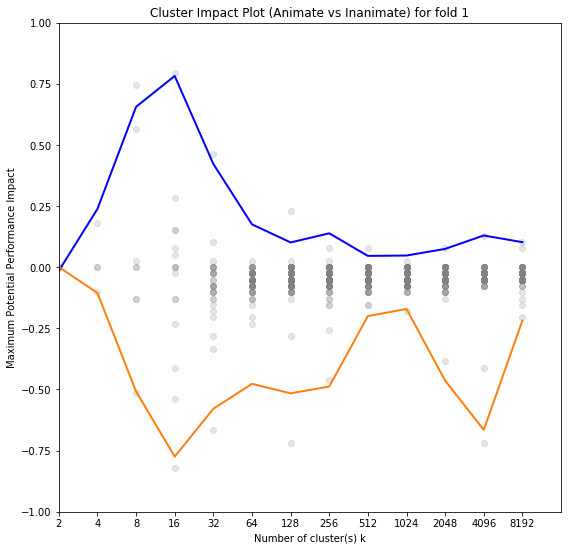

In [11]:
f = 1
clf_result = result[f]
from scipy.signal import savgol_filter

fig = plt.figure(1,figsize=(9,9))
X = range(1,14,1)
xticks = []
#X = range(2,51,1)
anat = []
inat = []
for cl in X:
    xticks.append(2**cl)
    i = 0
    temp = []
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'go',color='grey',alpha=0.2)
        temp.append(clf_result[cl][item])
        i += 1
    anat.append(np.max(temp))
    inat.append(np.min(temp))

ahat = savgol_filter(anat, 5, 3)
ihat =  savgol_filter(inat, 5, 3)       
plt.plot(X,ahat, color='b',linewidth=2)
plt.plot(X,ihat, color='C1',linewidth=2)
plt.ylim([-1,1])
plt.xlim([1,14])
plt.xticks(X,xticks)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Maximum Potential Performance Impact")
plt.title('Cluster Impact Plot (Animate vs Inanimate) for fold '+ str(f))
plt.axvline(x=23 , color='black', linestyle='--',alpha=0.3)
#plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))

plt.savefig('../../results/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=500)

In [ ]:
#Loading the pickle files
method ='GMM'

k = 4
result ={}
for i in range(1,k+1,1):
    name = '../../data/pkl/'+str(method)+'_30_scree_fold_'+str(i)+'_VGG16.pkl'   #CHANGE
    with open(name,"rb") as f:
        result[i] = pickle.load(f)

In [ ]:
result[1]

In [ ]:
from matplotlib.ticker import MaxNLocator
f = 1
clf_result = result[f]


fig = plt.figure(1)
X = range(1,31,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact")
plt.title('Performance Impact(Animate vs Inanimate) '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.savefig('../../results/'+str(method)+'_results_fold_'+str(f)+'.eps', format='eps')

In [ ]:
f = 2
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

In [ ]:
f = 3
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

In [ ]:
f = 4
clf_result = result[f]


fig = plt.figure(1)
X = range(1,51,1)
#X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance Impact(Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=200)

In [ ]:
#Find MaxAd', MaxId' and its average
plt.figure()
noc = 4
for i in range(1,noc+1,1):
    X = []
    Y = []
    for j in range(2,51,1):
        X.append(j)
        temp = []
        for key, value in result[i][j].items():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        avg = float(maxa - maxi)
        Y.append(avg)
    #print X,Y
    plt.plot(X,Y)

In [ ]:
#Smooth average graph
from scipy.interpolate import spline
noc = 4
flag = 0
X = range(2,51,1)
an_fold =[]
ian_fold = []
Y = []
for i in range(1,noc+1,1):
    if i == 2:
        flag = 1
    for j in range(2,51,1):
        temp = []
        for key, value in result[i][j].items():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        if flag == 0:
            an_fold.append(maxa)
            ian_fold.append(maxi)
        else:
            an_fold[j-2] += maxa
            ian_fold[j-2] = maxi

for j in range(2,51,1):
    maxa = (an_fold[j-2]) / 4.
    maxi = (ian_fold[j-2]) /4.
    diff = maxa - maxi
    Y.append(diff)
    
x_sm = np.array(X)
y_sm = np.array(Y)

x_smooth = np.linspace(x_sm.min(), x_sm.max(), 200)
y_smooth = spline(X, Y, x_smooth)

plt.plot(x_smooth, y_smooth, 'r', linewidth=1)
plt.plot(Y.index(max(Y))+1,max(Y),'o')
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Average Performance")
plt.savefig('../../results/scree/'+str(method)+'_results_fold_avg.png', format='png', dpi=200)
print(max(Y), Y.index(max(Y)) + 1)